In [ ]:
!pip install arch

In [ ]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [ ]:
start = datetime(2022, 9, 17)
end = datetime(2024, 1, 23)

In [ ]:
btc_usd = yf.download('BTC-USD', start=start, end=end)
btc_usd.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-09-17,19777.033203,20162.531250,19777.033203,20127.576172,20127.576172,24957448100
2022-09-18,20127.234375,20127.234375,19387.492188,19419.505859,19419.505859,31254779144
2022-09-19,19418.572266,19639.480469,18390.318359,19544.128906,19544.128906,40177002624
2022-09-20,19545.591797,19602.457031,18813.455078,18890.789062,18890.789062,36791346508
2022-09-21,18891.283203,19674.630859,18290.314453,18547.400391,18547.400391,46363793975


In [ ]:
returns = 100 * btc_usd.Close.pct_change().dropna()
# процентное изменение цен с интервалом в 1 день

Text(0.5, 1.0, 'BTC-USD Returns')

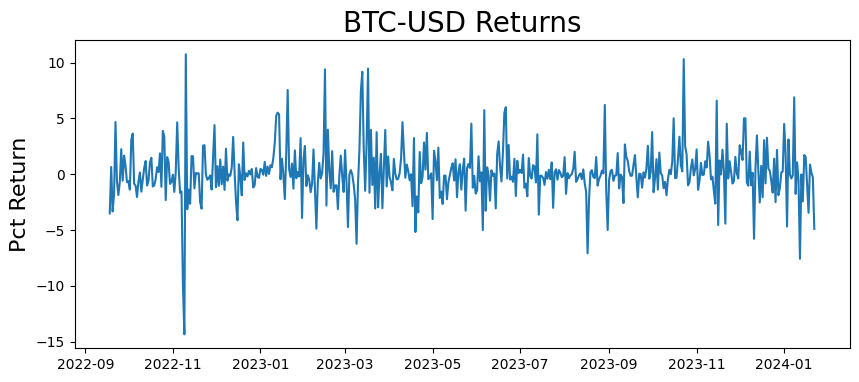

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('BTC-USD Returns', fontsize=20)

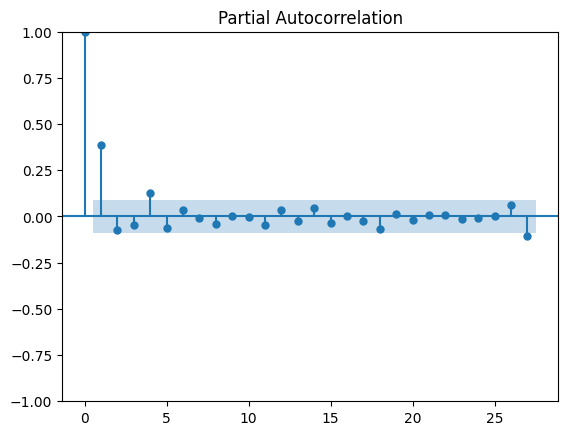

In [ ]:
plot_pacf(returns**2)
plt.show()

In [ ]:
model = arch_model(returns, p=4, q=1)

In [ ]:
model_fit = model.fit()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 1541.9944525467
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1709.1628122337422
Iteration:      3,   Func. Count:     28,   Neg. LLF: 2096.091006747985
Iteration:      4,   Func. Count:     37,   Neg. LLF: 1133.8168005350715
Iteration:      5,   Func. Count:     46,   Neg. LLF: 1103.5700905322992
Iteration:      6,   Func. Count:     54,   Neg. LLF: 1100.7100269555826
Iteration:      7,   Func. Count:     62,   Neg. LLF: 1099.8543486214453
Iteration:      8,   Func. Count:     70,   Neg. LLF: 1173.0340753120436
Iteration:      9,   Func. Count:     80,   Neg. LLF: 1102.7424449472046
Iteration:     10,   Func. Count:     89,   Neg. LLF: 1098.5255392055772
Iteration:     11,   Func. Count:     97,   Neg. LLF: 1098.4430595123429
Iteration:     12,   Func. Count:    105,   Neg. LLF: 1098.4374400441907
Iteration:     13,   Func. Count:    113,   Neg. LLF: 1098.4362136236496
Iteration:     14,   Func. Count:    121,   Neg. LLF: 1

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1098.44
Distribution:                  Normal   AIC:                           2210.87
Method:            Maximum Likelihood   BIC:                           2240.26
                                        No. Observations:                  492
Date:                Sun, Jun 09 2024   Df Residuals:                      491
Time:                        15:49:45   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1166      0.143      0.816      0.415 [ -0.164,  0.397]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          3.5980      2.709      1.328      0.184    [ -1.712,  8.908]
alpha[1]       0.2658      0.131      2.036  4.179e-02  [9.872e-03,  0.522]
alpha[2]   5.8755e-03  8.018e-02  7.328e-02      0.942    [ -0.151,  0.163]
alpha[3]       0.0000      0.609      0.000      1.000    [ -1.194,  1.194]
alpha[4]       0.1012  5.363e-02      1.887  5.916e-02 [-3.914e-03,  0.206]
beta[1]        0.0000      0.315      0.000      1.000    [ -0.616,  0.616]
===========================================================================

Covariance estimator: robust
"""

In [ ]:
rolling_predictions = []
test_size = 90

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=3, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [ ]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-90:])

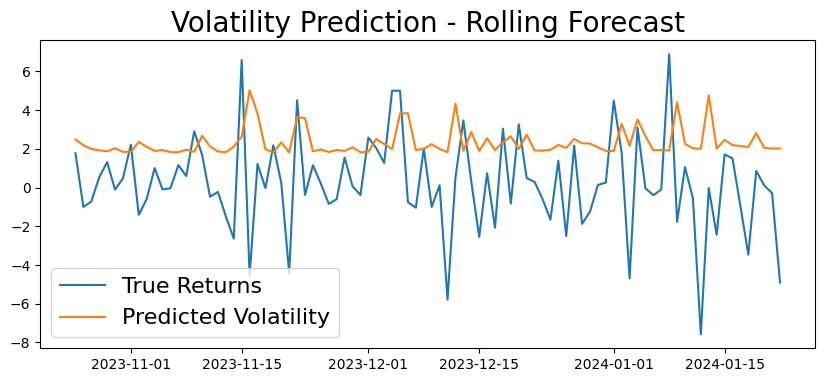

In [ ]:
plt.figure(figsize=(10,4))
true, = plt.plot(returns[-90:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

In [ ]:
train = returns[:-7]
model = arch_model(train, p=3, q=0)
model_fit = model.fit(disp='off')
plt.show()

In [ ]:
pred = model_fit.forecast(horizon=7)
future_dates = [returns.index[-8] + timedelta(days=i) for i in range(1,8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

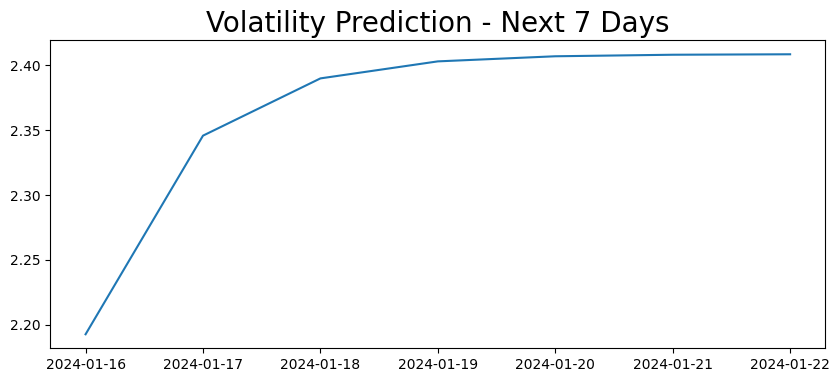

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)

In [ ]:
import random
def simulate_next_day_price(start_price, volatilities):
    next_day_prices = []
    current_price = start_price

    for date, volatility in volatilities.items():
        # Generate a random number from a standard normal distribution
        random_number = random.gauss(0, 1)

        # Calculate the next day's price
        next_day_price = current_price * (1 + volatility * random_number/100)
        next_day_prices.append((date, next_day_price))

        # Update the current price for the next iteration
        current_price = next_day_price

    return next_day_prices

In [ ]:
start_price = btc_usd.Close[-6]
actual_price = btc_usd.Close[-7:]
volatilities = pred
next_day_prices = simulate_next_day_price(start_price, volatilities)
next_day_prices = pd.Series([price for date, price in next_day_prices], index=[date for date, price in next_day_prices])

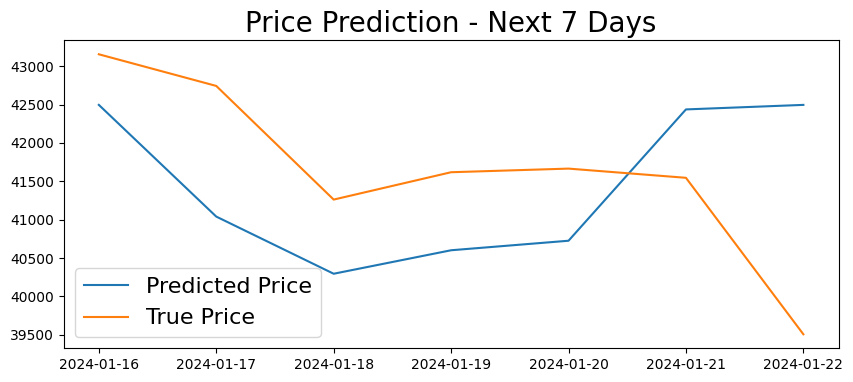

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(next_day_prices)
plt.plot(actual_price)
plt.title('Price Prediction - Next 7 Days', fontsize=20)
plt.legend(['Predicted Price', 'True Price'], fontsize=16)

In [ ]:
data = yf.download('BTC-USD', start='2023-01-01', end='2024-05-01')

prices = data['Close'].values.reshape(-1, 1)

news_sentiment = np.random.rand(len(prices), 1)

features = np.hstack((prices, news_sentiment))

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
look_back = 5
X, Y = create_dataset(scaled_features, look_back)

X = X.reshape((X.shape[0], look_back, 2))

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 2)))
model.add(LSTM(50))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

model.fit(X_train, Y_train, epochs=5, batch_size=1, verbose=1)

Epoch 1/5
384/384 [==============================] - 12s 12ms/step - loss: 0.0023
Epoch 2/5
384/384 [==============================] - 4s 10ms/step - loss: 7.5389e-04
Epoch 3/5
384/384 [==============================] - 4s 10ms/step - loss: 7.8283e-04
Epoch 4/5
384/384 [==============================] - 5s 12ms/step - loss: 8.4992e-04
Epoch 5/5
384/384 [==============================] - 3s 7ms/step - loss: 7.9349e-04


In [ ]:
future_days = 30
future_predictions = []
current_batch = scaled_features[-look_back:].reshape(1, look_back, 2)

for i in range(future_days):
    future_pred = model.predict(current_batch)[0][0]
    new_row = np.array([future_pred, current_batch[0, -1, 1]]).reshape(1, 1, 2)
    current_batch = np.append(current_batch[:, 1:, :], new_row, axis=1)
    future_predictions.append(future_pred)

future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions_scaled = scaler.inverse_transform(
    np.hstack((future_predictions, np.zeros((future_predictions.shape[0], 1)))))
future_predictions_inversed = future_predictions_scaled[:, 0]

last_date = data.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_days, freq='D')

1/1 [==============================] - 0s 22ms/step


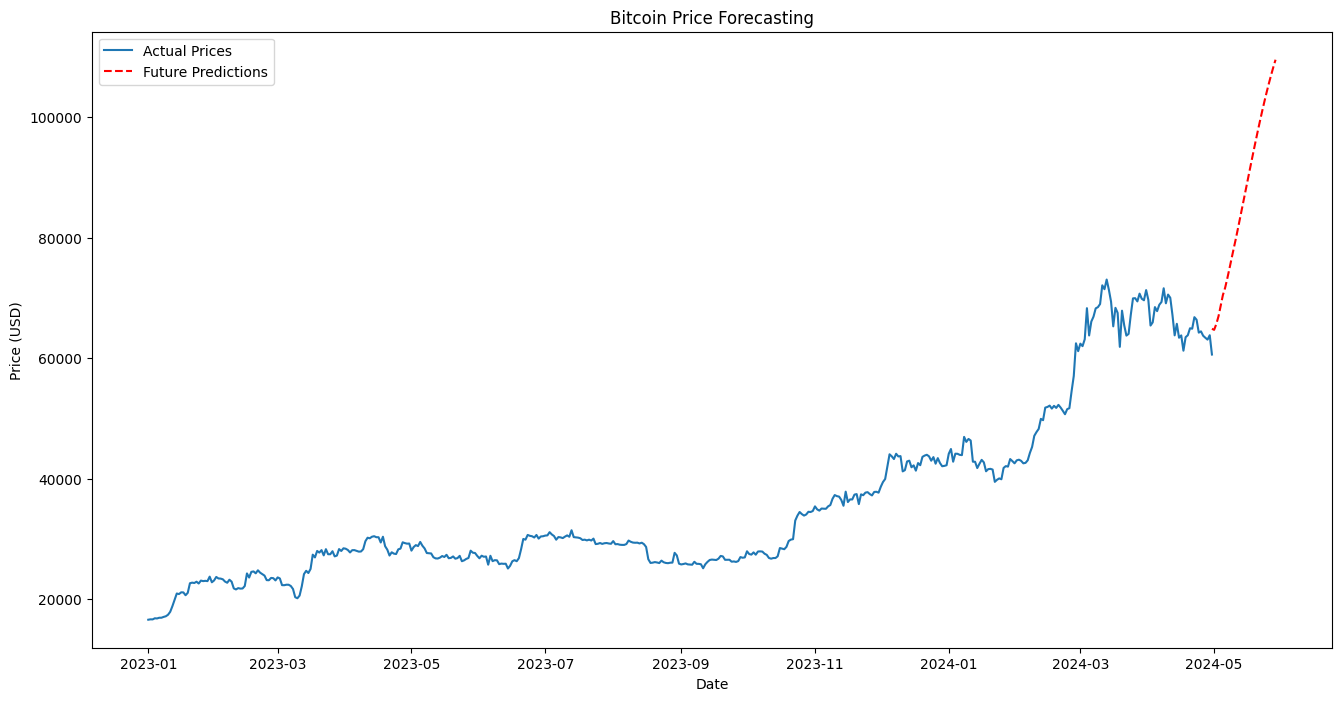

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(data.index, prices, label='Actual Prices')
plt.plot(future_dates, future_predictions_inversed, label='Future Predictions', linestyle='--', color='red')
plt.title('Bitcoin Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()